In [1]:
# Bibliotecas básicas de data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib inline

# Para baixar os dados
import yfinance as yf


#Para aplicar o ARIMA:
from statsmodels.tsa.stattools import adfuller          #verificar dados estacionários
from statsmodels.tsa.stattools import acf, pacf         #correlação
from statsmodels.tsa.seasonal import seasonal_decompose #Decomposição sazonal usando médias móveis.
from statsmodels.tsa.arima.model import ARIMA           #algoritmo arima

# Para deep learning
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from keras.preprocessing.sequence import TimeseriesGenerator

# Para machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# Prophet
from prophet import Prophet

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [2]:
#!pip uninstall -y fbprophet
#!pip uninstall -y pystan
#!pip install fbprophet
#!pip install pystan==2.19.1.1

In [3]:
df = pd.read_excel('/content/Dados Históricos - Ibovespa.xlsx')

In [4]:
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,2019-01-02,134185,134194,134389,133832,"7,81M",-0.0001
1,2019-01-03,134194,133523,134195,133328,"6,17M",0.0049
2,2019-01-04,133533,132753,133645,132753,"5,15M",0.0059
3,2019-01-07,132753,132182,133035,132094,"8,23M",0.0043
4,2019-01-08,132182,130826,132277,130822,"8,68M",0.0105


In [5]:
from datetime import datetime

In [6]:
df['Data'] = pd.to_datetime(df['Data'])


In [7]:
df.head()


,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,2019-01-02,134185,134194,134389,133832,"7,81M",-0.0001
1,2019-01-03,134194,133523,134195,133328,"6,17M",0.0049
2,2019-01-04,133533,132753,133645,132753,"5,15M",0.0059
3,2019-01-07,132753,132182,133035,132094,"8,23M",0.0043
4,2019-01-08,132182,130826,132277,130822,"8,68M",0.0105


In [8]:
df_ibovespa = df

In [9]:
df.index = pd.to_datetime(df.Data, format = "%m-%d-%Y")

In [10]:
df.drop(columns=['Abertura','Máxima','Mínima','Vol.','Var%'])

,Data,Último
Data,,
2019-01-02,2019-01-02,134185
2019-01-03,2019-01-03,134194
2019-01-04,2019-01-04,133533
2019-01-07,2019-01-07,132753
2019-01-08,2019-01-08,132182
...,...,...
2023-12-21,2023-12-21,92032
2023-12-22,2023-12-22,91699
2023-12-26,2023-12-26,91841


In [12]:
#Filtrando os dados
df = pd.DataFrame(df[['Último','Data']])
df.set_index('Data', inplace=True)

In [13]:
df['MA_window_10'] = df['Último'].rolling(10).mean().shift() #média móvel em 10 dias
df['MA_window_20'] = df['Último'].rolling(20).mean().shift() #média móvel em 20 dias

In [14]:
df.head(20)

,Último,MA_window_10,MA_window_20
Data,,,
2019-01-02,134185,NaN,NaN
2019-01-03,134194,NaN,NaN
2019-01-04,133533,NaN,NaN
2019-01-07,132753,NaN,NaN
2019-01-08,132182,NaN,NaN
2019-01-09,130804,NaN,NaN
2019-01-10,131851,NaN,NaN
2019-01-11,131084,NaN,NaN
2019-01-14,130197,NaN,NaN


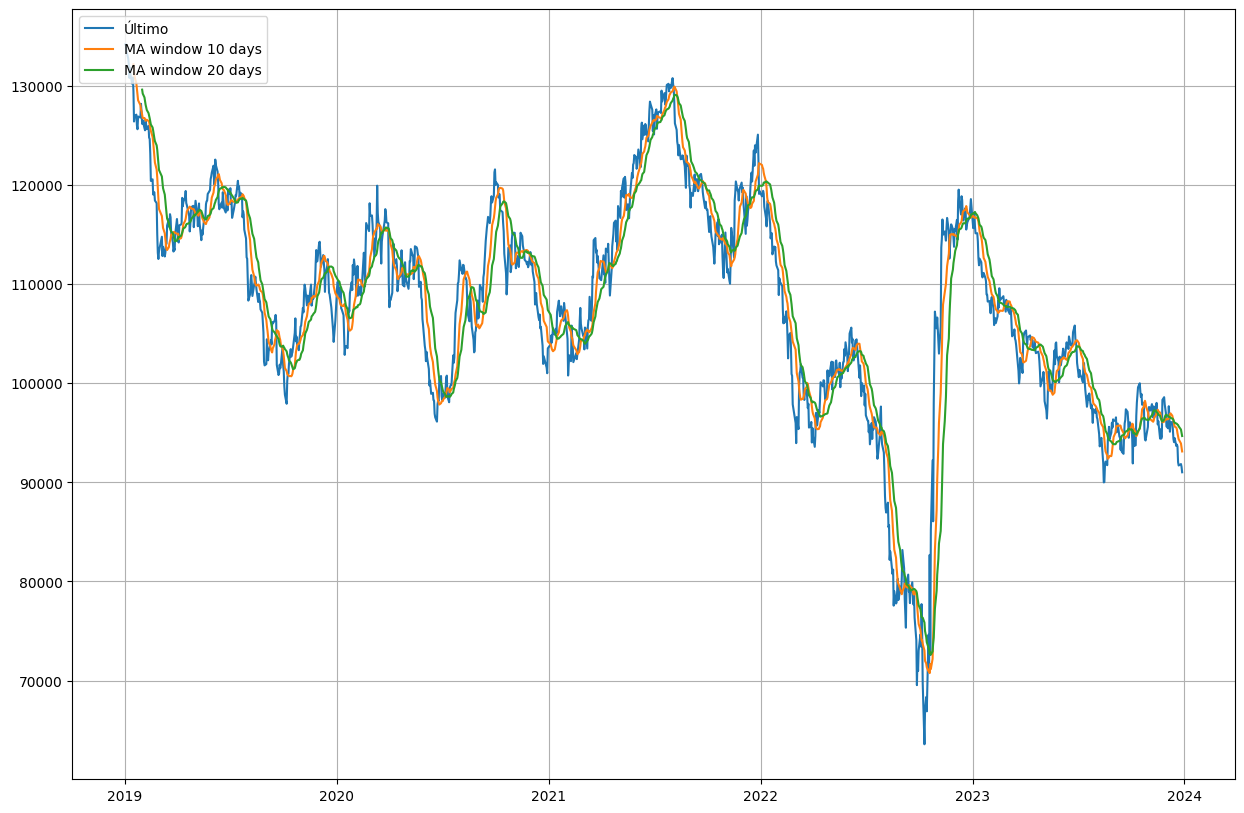

In [15]:
plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(df['Último'], label='Último')
plt.plot(df['MA_window_10'], label='MA window 10 days')
plt.plot(df['MA_window_20'], label='MA window 20 days')
plt.legend(loc=2)
plt.show()

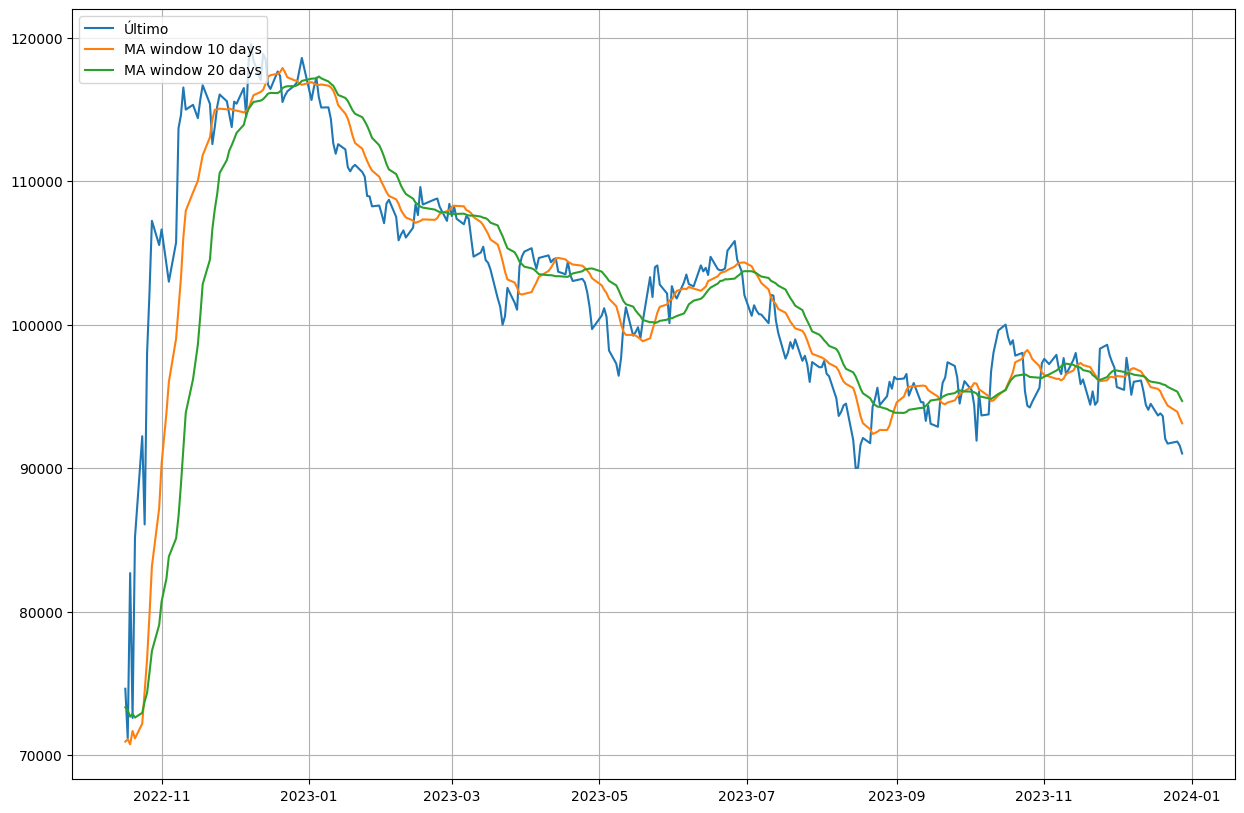

In [16]:
limit = 300

plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(df['Último'][-limit:], label='Último')
plt.plot(df['MA_window_10'][-limit:], label='MA window 10 days')
plt.plot(df['MA_window_20'][-limit:], label='MA window 20 days')
plt.legend(loc=2)
plt.show()

In [17]:
df['MA_window_10_forward_10'] = np.NaN

In [18]:
def make_window(window_size, start_point):
    return [start_point+x for x in range(window_size)]

In [19]:
def make_window(window_size, start_point):
    return [start_point+x for x in range(window_size)]

In [21]:
window_size = 10
forward_days = 10

# Iteração sobre a série temporal com uma janela deslizante
for index in range(window_size, len(df), forward_days):

    # Iteração para calcular a média móvel ponderada
    for i in range(0, forward_days):
        # Verifica se o índice atual está dentro dos limites da série temporal
        if index + i >= len(df):
            break

        # Criando duas janelas:
        # 1. Uma janela para a média móvel ('window_close')
        # 2. Uma janela para a série temporal original ('window_MA')
        window_close = make_window(window_size - i, index + i - window_size)
        window_MA = make_window(i, index)

        # Calculando a média móvel ponderada
        mean = pd.concat([df['Último'].iloc[window_close], df['MA_window_10_forward_10'].iloc[window_MA]]).mean(axis=0)

        # Atualizando o DataFrame com a média móvel ponderada
        df.iat[index + i, df.columns.get_loc('MA_window_10_forward_10')] = mean

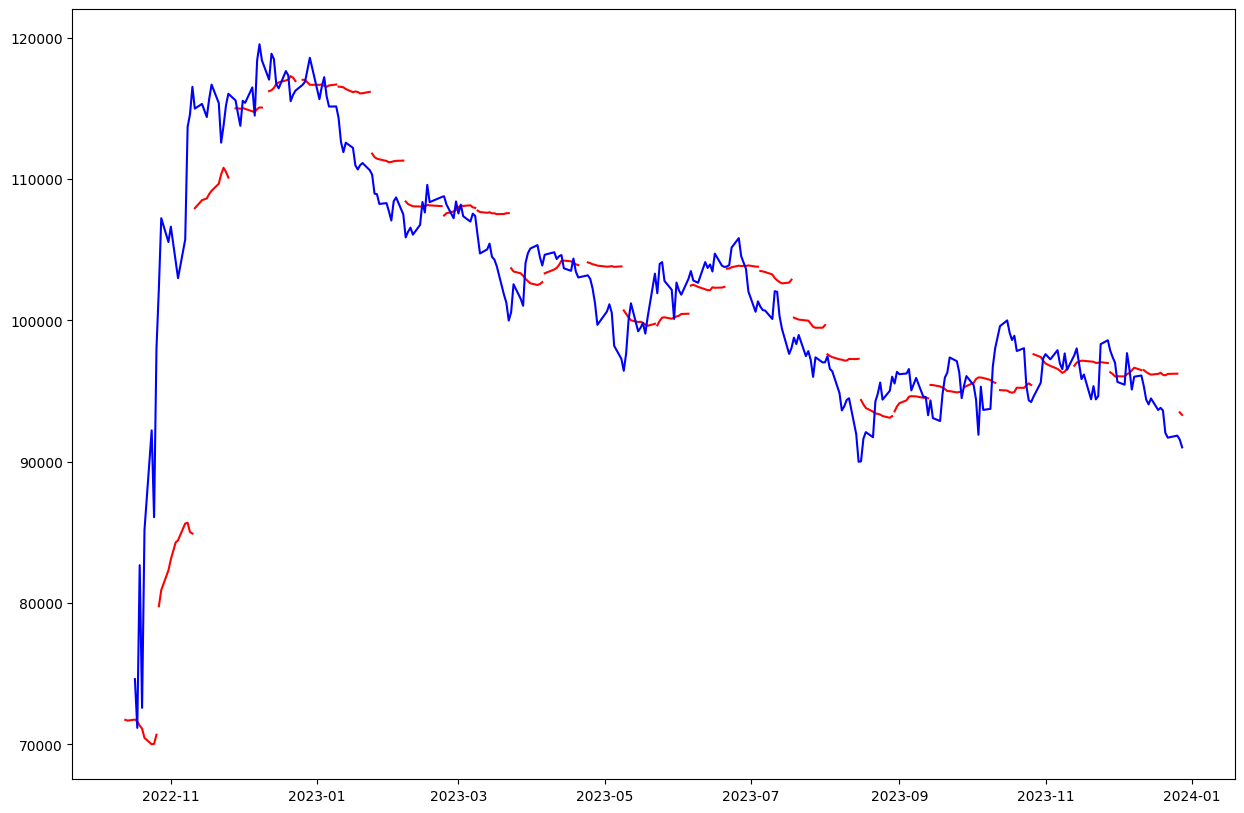

In [22]:
plt.figure(figsize = (15,10))

size = len(df)-limit - (len(df)-limit)%forward_days

for index in range(size, len(df), forward_days):
    plt.plot(df['MA_window_10_forward_10'][index:index+forward_days], color='r')

plt.plot(df['Último'][-limit:], color='b', label='Último')
#plt.legend(loc='best')
plt.show()